In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 16 10:22:29 2016
This is a Python program to extract resonator quality factor using nonlinear fit. 
The following libraries are adapted from the codes from qkitgroup : https://github.com/qkitgroup/qkit
*calibration.py
*circlefit.py
*circuit.py
*utilities.py
@author: Wenyuan Zhang , wzhang@physics.rutgers.edu
Modified to fit HFSS data output by Wen-Sen, wslu@gmail.com
"""
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as spopt
from scipy import stats
from circuit import *
from utilities import phase_vs_freq
from pprint import pprint
from copy import deepcopy

def loaddata(fname):
    df = pd.read_csv(fname)
    f     = df['Freq [GHz]'].to_numpy()
    mag   = df['mag(S(2,1)) []'].to_numpy()
    phase = df['ang_rad(S(2,1)) []'].to_numpy()
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    return f, S21, df

def fr_Ql_init(f,S21):
    S21 = S21 / np.abs(S21)[0]
    S21_abs= np.abs(S21)
    S21_FWHM = 1/2*(np.min(S21_abs)**2+1)
#     print(S21_FWHM)
    fr_index = np.argmin(S21_abs)
    fr = f[fr_index]
    f_left = f[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    S21_left = S21_abs[np.argmin(np.abs(S21_FWHM-S21_abs[0:fr_index]))]
    f_right = f[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    S21_right = S21_abs[fr_index+np.argmin(np.abs(S21_FWHM-S21_abs[fr_index:-1]))]
    Ql = fr/(f_right-f_left)
    if False:
        plt.subplots()
        plt.title('init fr, Ql')
        plt.plot(f,S21_abs)
    S21_sim = (np.min(S21_abs)+2j*Ql*(1-f/fr))/(1+2j*Ql*(1-f/fr))
    if False:
        plt.plot(f,np.abs(S21_sim),f_left,S21_left,'o',f_right,S21_right,'o')
    return fr, Ql


In [7]:
def resFit(f,S21, verbose = False, REMOVE_BACKGND = False):
    angles=np.linspace(0,2*np.pi,2000)
    port = notch_port(f,S21)

    if False:
        index=np.arange(580,802)
        f_data_origin=f[index]
        z_data_origin=S21[index]
    else:
        f_data_origin=f
        z_data_origin=S21
    
    f_data=f_data_origin
    z_data=z_data_origin

    if verbose:
        plt.subplots(2,1)
        plt.suptitle('Raw data')
        plt.subplot(211)
        plt.plot(f_data,np.abs(z_data),'+-')
        plt.subplot(212)
        plt.plot(f_data,np.angle(z_data),'+-')

    if REMOVE_BACKGND:
        linear_var = -22
        z_data = z_data/(1+linear_var*(f_data/frcal-1)) 
    else: 
        linear_var = 0
    
    delay = port._guess_delay(f_data,z_data)
    delay = port._fit_delay(f_data,z_data,delay,maxiter=200)
    A1, A2, A3, A4, frcal, Ql=port._fit_skewed_lorentzian(f_data,z_data)
    z_data = z_data_origin*np.exp(2.*1j*np.pi*delay*f_data)
    
    if REMOVE_BACKGND:
        plt.subplots()
        plt.title('|S21| before and after background slope removed')
        plt.plot(f_data_origin,np.absolute(z_data_origin),'+')
        plt.plot(f_data,np.absolute(z_data),'.')

    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)

    [plt.subplots() for _ in [1] if verbose]
    [plt.plot(np.real(z_data),np.imag(z_data),'.') for _ in [1] if verbose]
    [plt.title('circle fit') for _ in [1] if verbose]
    xc, yc, r0 = port._fit_circle(z_data,refine_results=True)
    [plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles)) for _ in [1] if verbose]
## 
    zc = np.complex(xc,yc)
    theta = np.angle(port._center(z_data,zc))[np.argmin(f_data-frcal)]
    theta=-4
    fitparams = port._phase_fit(f_data,port._center(z_data,zc),theta,np.absolute(Ql),frcal)
    theta, Ql, fr = fitparams
    [plt.subplots() for _ in [1] if verbose]
    [plt.title('phase fit before after') for _ in [1] if verbose]
    _phase = np.angle(port._center(z_data,zc)) 
    [plt.plot(f_data,np.unwrap(_phase),'.') for _ in [1] if verbose]

    if Ql<0:
        raise('Ql is less than zero')
    _phase = theta+2.*np.arctan(2.*Ql*(1.-f_data/fr))
    [plt.plot(f_data, _phase) for _ in [1] if verbose]
    beta = theta + np.pi
    offrespoint = np.complex((xc+r0*np.cos(beta)),(yc+r0*np.sin(beta)))
    alpha = np.angle(offrespoint)
    a = np.absolute(offrespoint)
    if verbose:
        plt.subplots()
        plt.title('off res point')
        plt.plot(np.real(z_data),np.imag(z_data),'.-')
        plt.plot(xc+r0*np.cos(angles),yc+r0*np.sin(angles))
        plt.plot(offrespoint.real,offrespoint.imag,'o')
    # normalize 
    z_data = z_data/a*np.exp(1j*(-alpha))
    if verbose:
        plt.subplots()
        plt.title('after normalization')
        plt.plot(z_data.real,z_data.imag,'.')
        plt.xlim(-2,2)
        plt.ylim(-2,2)
    
    port.fitresults = port.circlefit(f_data,z_data,fr,Ql,refine_results=True,calc_errors=True,m=20)
    
    z_data_sim = port._S21_notch(f_data,fr=port.fitresults["fr"],Ql=port.fitresults["Ql"],Qc=port.fitresults["absQc"],phi=port.fitresults["phi0"],a=a,alpha=alpha,delay=delay) * (1+linear_var*(f_data/port.fitresults["fr"]-1))
    
    if verbose:
        plt.subplots(2,1)
        plt.subplot(2,1,1)
        plt.title('raw data vs simulated data, Mag')
        plt.plot(f_data_origin,np.abs(z_data_origin),'+')
        plt.plot(f_data,np.abs(z_data_sim))
        plt.subplot(2,1,2)
        plt.title('raw data vs simulated data, phase')
        plt.plot(f_data_origin,np.angle(z_data_origin),'+')
        plt.plot(f_data,np.angle(z_data_sim))
    
    results = np.array([
                        port.fitresults['fr'],
                        port.fitresults['Qi_dia_corr'],
                        port.fitresults['Qi_dia_corr_err'],
                        port.fitresults['Qi_no_corr'],
                        port.fitresults['Qi_no_corr_err'],
                        port.fitresults['absQc'],
                        port.fitresults['absQc_err'],
                        port.fitresults['Qc_dia_corr'],
                        port.fitresults['Ql'],
                        port.fitresults['Ql_err'],
                        port.fitresults['chi_square_'],
                        delay,
                        a,
                        port.fitresults['Qc_dia_corr_err']
                      ])
    results = np.reshape(results,(1,results.size))
    [print('===========Results===========') for _ in [1] if verbose]
    [pprint(port.fitresults) for _ in [1] if verbose]
    
    [print('average number of photons in resonator at -130dBm input power', port.get_photons_in_resonator(-130)) for _ in [1] if verbose]
    [print('single photon limit power at input port(dBm)',port.get_single_photon_limit()) for _ in [1] if verbose]

    return port.fitresults['Ql'], port.fitresults['Qi_dia_corr'], port.fitresults['Qc_dia_corr']

<IPython.core.display.Javascript object>


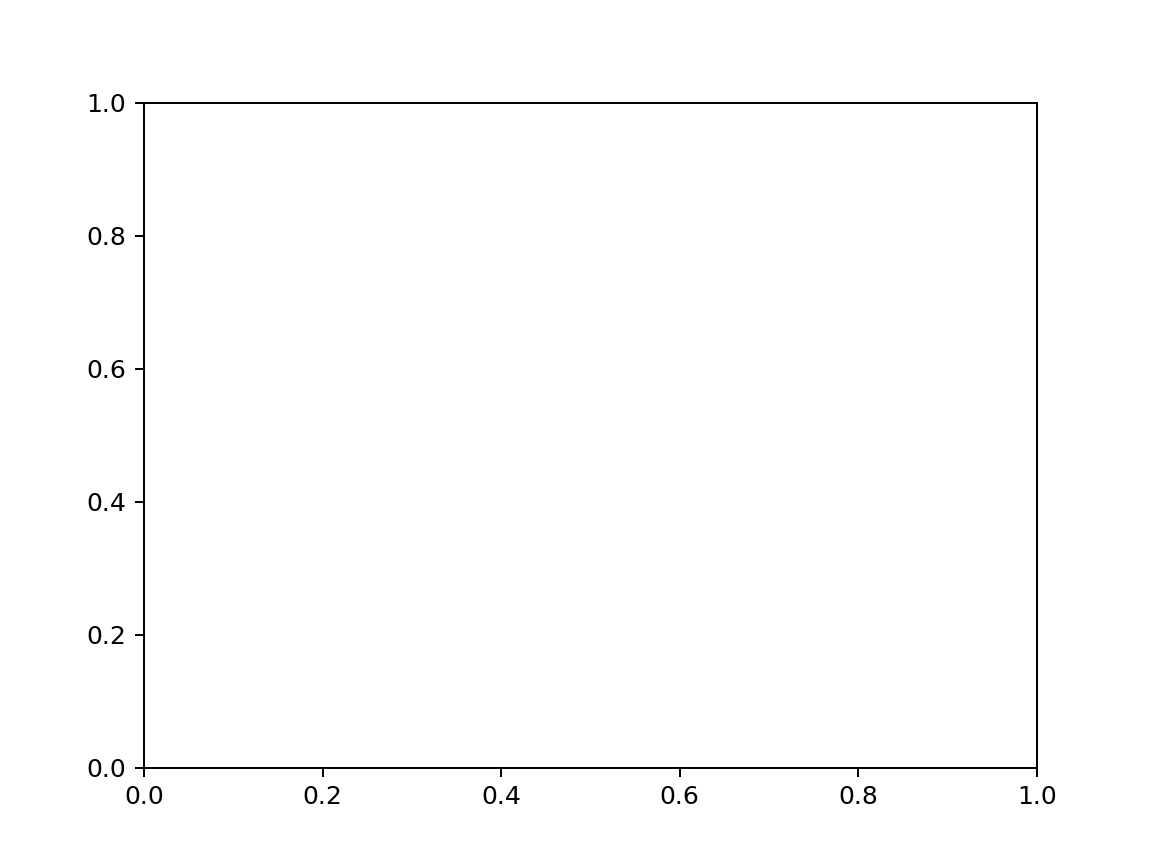

ValueError: x and y must have same first dimension, but have shapes (1,) and (401,)

In [12]:
%matplotlib notebook
f,ax = plt.subplots()
ax.plot(f, mag,'x')

In [15]:
2**76

75557863725914323419136

<IPython.core.display.Javascript object>


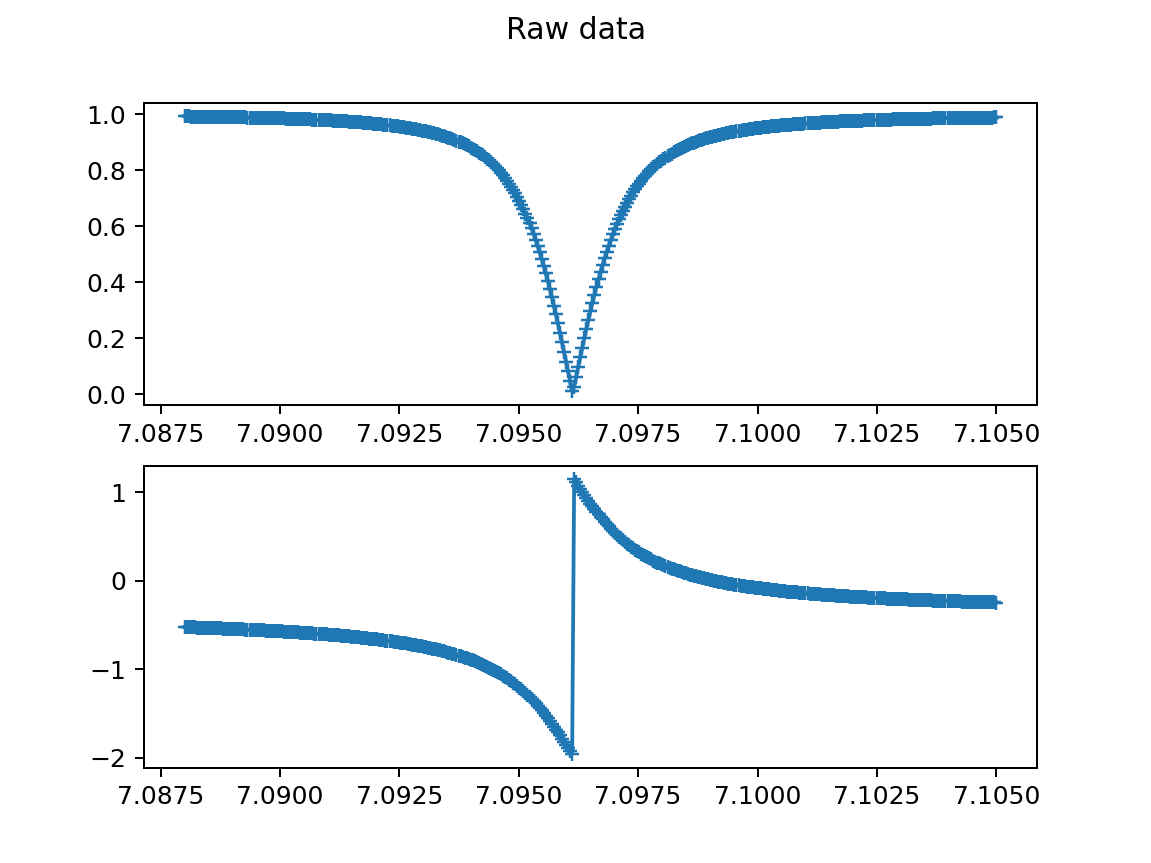

<IPython.core.display.Javascript object>


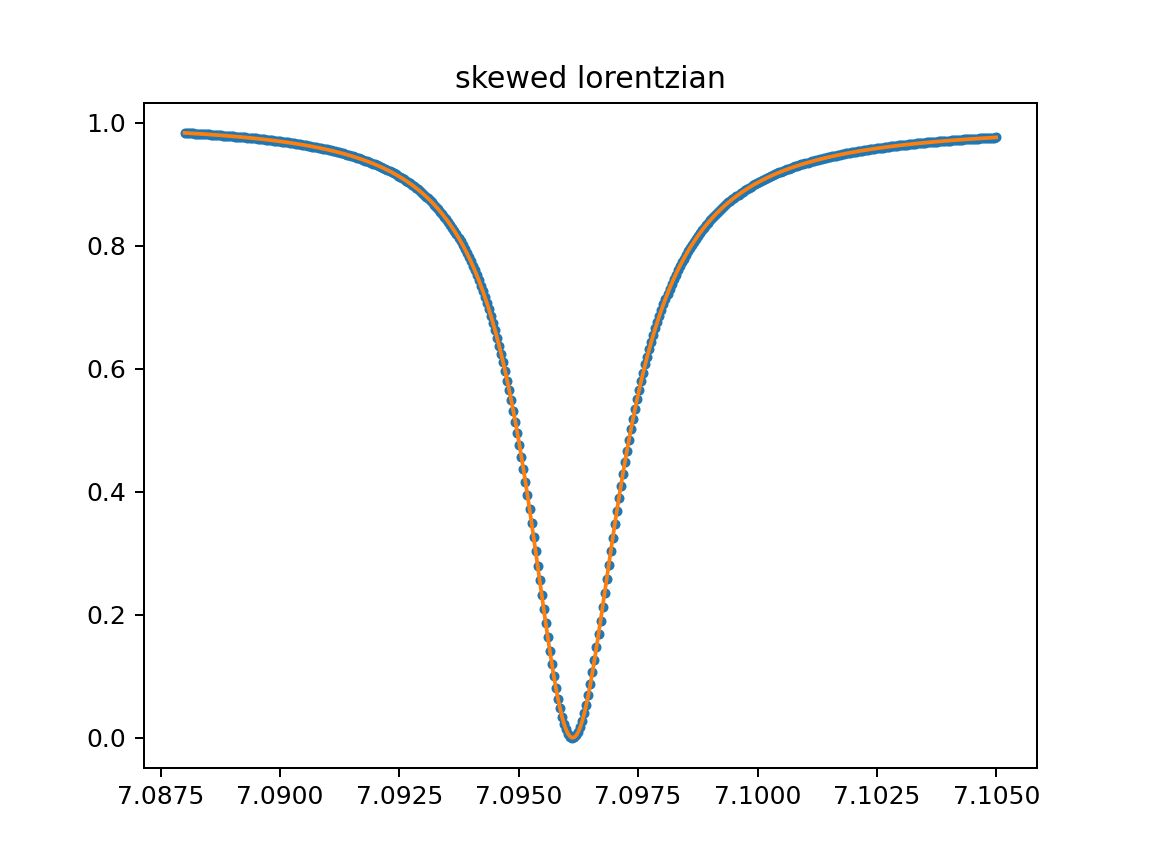

agebraic r0: 0.499898917041372
iterative r0: 0.4998989170413737


<IPython.core.display.Javascript object>


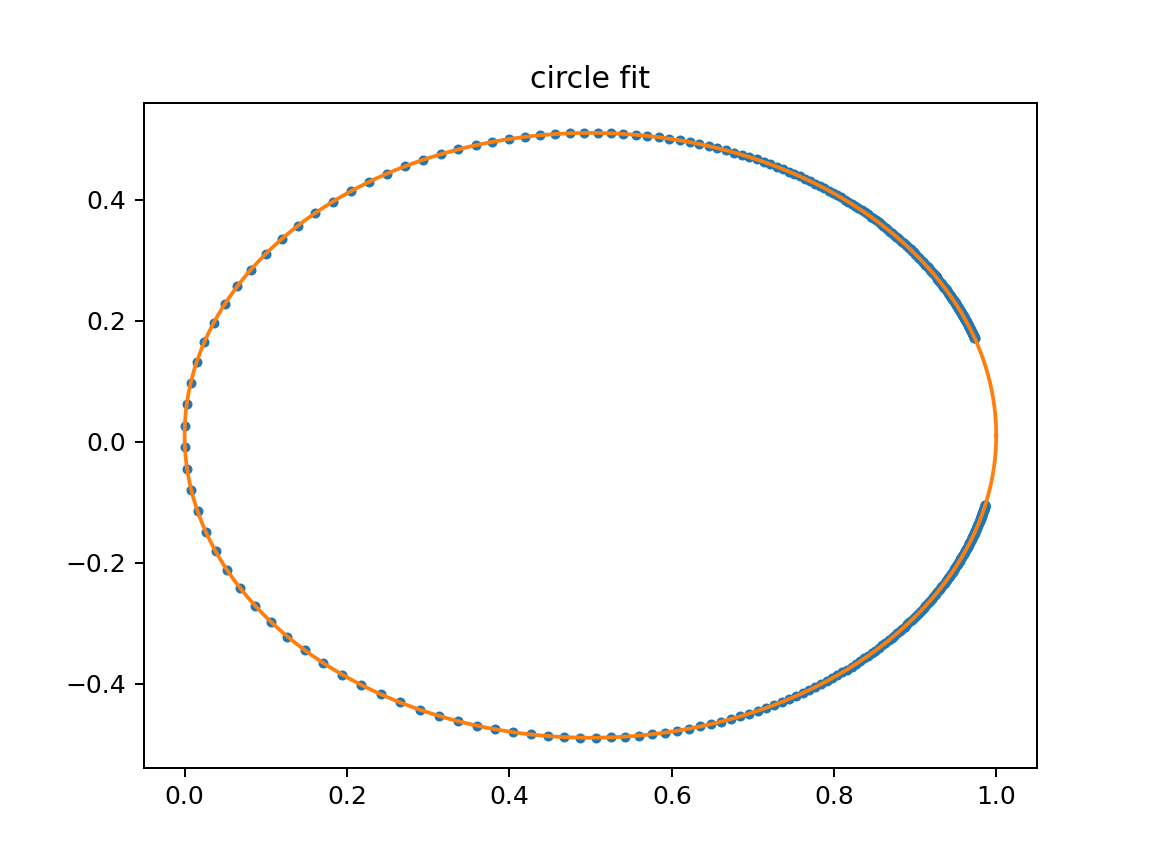

agebraic r0: 0.499898917041372
iterative r0: 0.4998989170413737


<IPython.core.display.Javascript object>


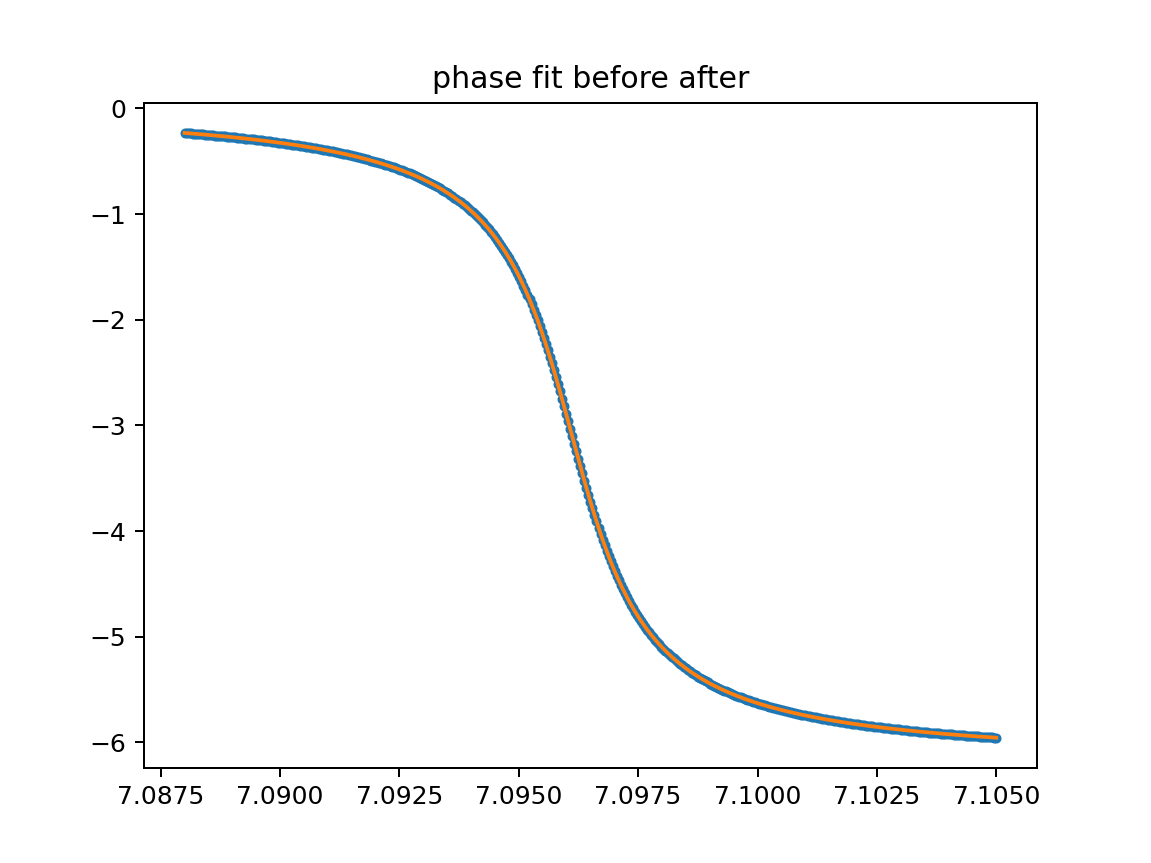

<IPython.core.display.Javascript object>


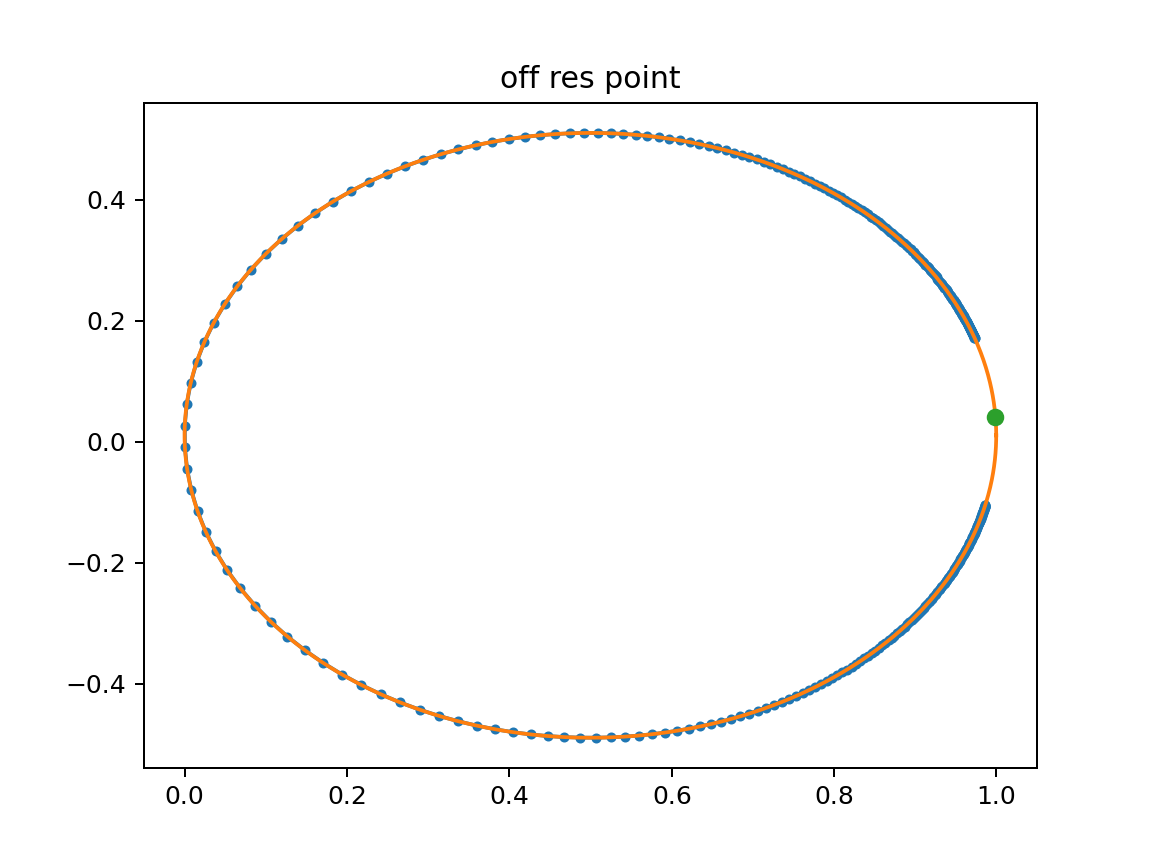

<IPython.core.display.Javascript object>


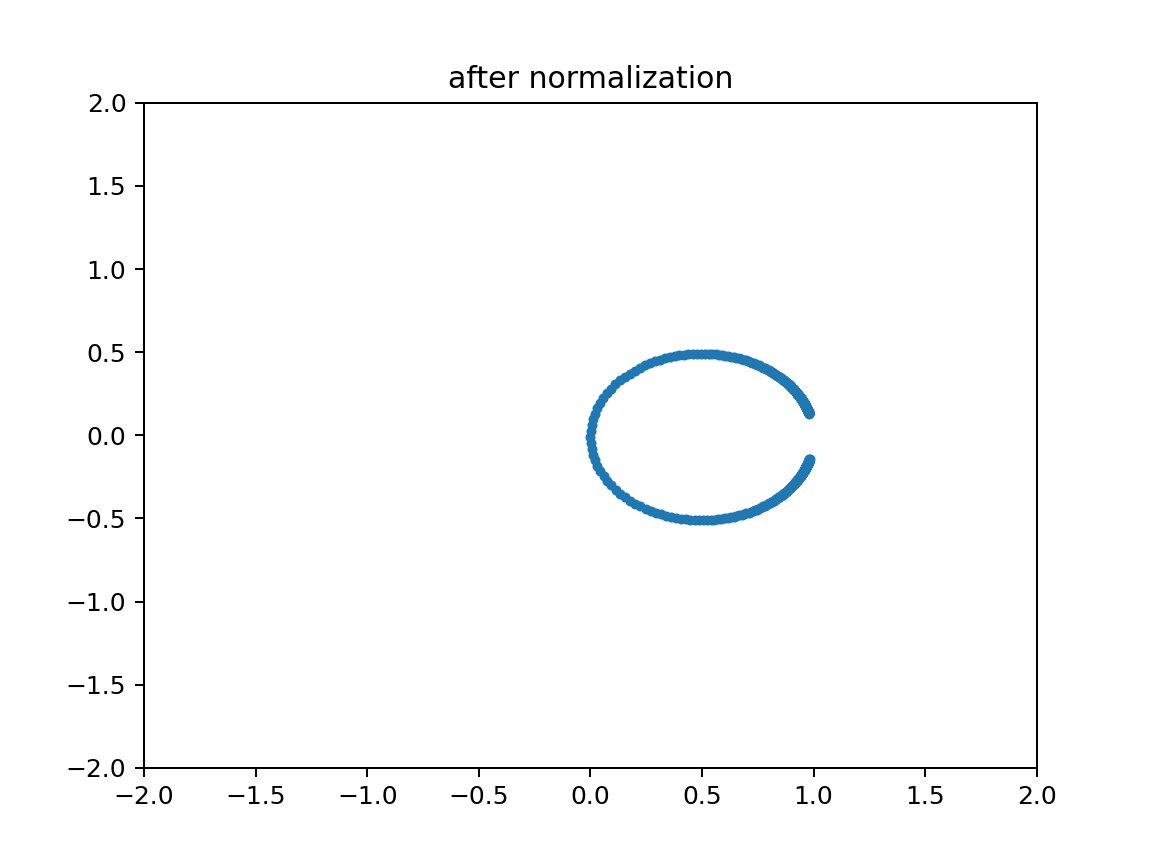

agebraic r0: 0.500096617425617
iterative r0: 0.5000966174256124


<IPython.core.display.Javascript object>


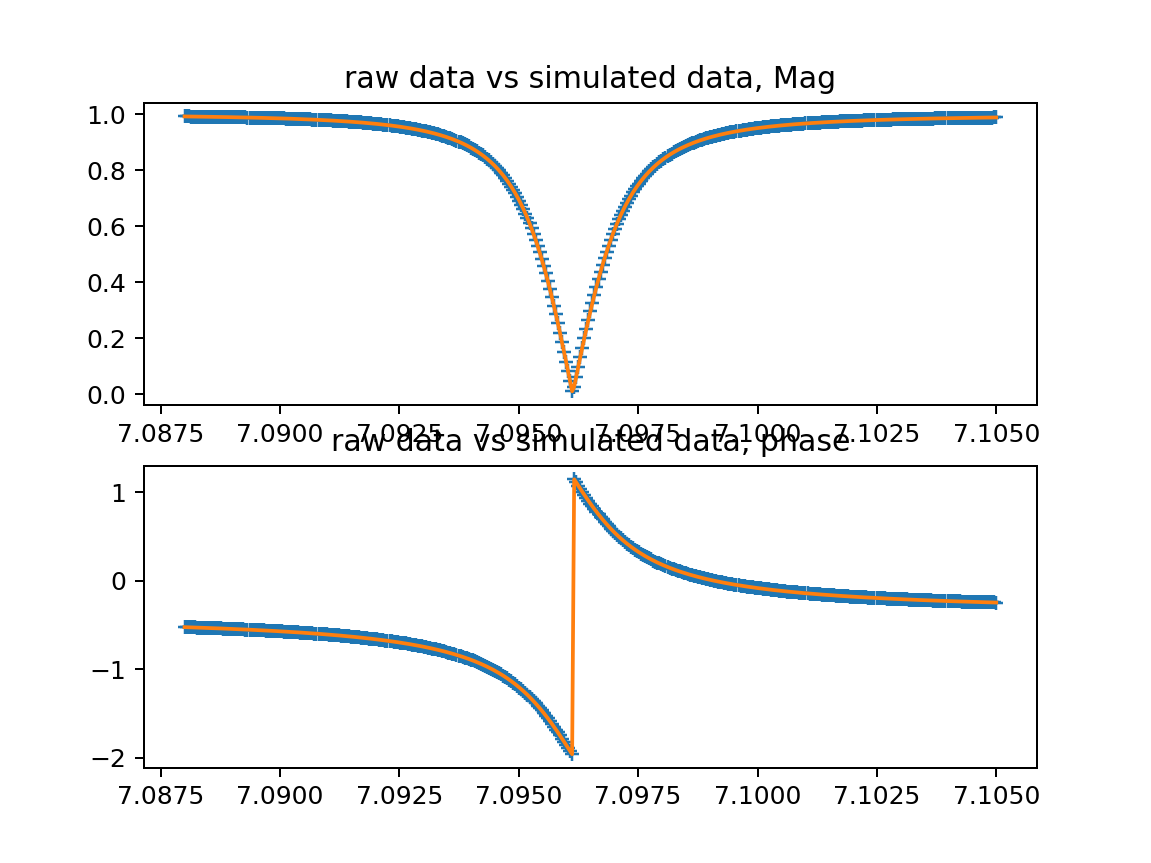

===========Results===========
{'Qc_dia_corr': 2980.5312121767124,
 'Qc_dia_corr_err': 2.486535608024401,
 'Qi_dia_corr': -779606528588.8242,
 'Qi_dia_corr_err': 1.0262077745833767e+19,
 'Qi_no_corr': -15424397.848945757,
 'Qi_no_corr_err': 4020441743.289712,
 'Ql': 2980.5312235716483,
 'Ql_err': 150.12252615764595,
 'absQc': 2979.955392334754,
 'absQc_err': 0.02362401580452159,
 'chi_square_': 6.444594346286968e-06,
 'fr': 7.09610546591766,
 'fr_err': 5.0512531694221156e-05,
 'phi0': 0.019657055593437636,
 'phi0_err': 0.04243331794678175,
 'residue': 4.51295780453011e-10,
 'theta0': -3.1219355979963557}
average number of photons in resonator at -130dBm input power 2.843463463001555
single photon limit power at input port(dBm) -134.53847652170126


,G_CP [um],L_CP [um],Ql,Qi,Qc
0,0.0,0.0,0.000000,0.000000e+00,0.000000
1,1.0,200.0,2980.531224,-7.796065e+11,2980.531212


In [13]:
Qdic = {'G_CP [um]': 0, 'L_CP [um]': 0, 'Ql':0, 'Qi':0, 'Qc':0}
dfR = pd.DataFrame(data = Qdic, index = [0])

_, _, df = loaddata('1.csv')
dflst = []
for i in range(df.shape[0]//401):
    dflst += [df.iloc[401*i:401*(i+1)]]

for dfl in dflst:
    f     = dfl['Freq [GHz]'].to_numpy()
    mag   = dfl['mag(S(2,1)) []'].to_numpy()
    phase = dfl['ang_rad(S(2,1)) []'].to_numpy()
    S21 = mag*np.cos(phase)+1j*mag*np.sin(phase)
    Ql, Qi, Qc = resFit(f, S21, verbose = True)
    s = df[['G_CP [um]', 'L_CP [um]']].iloc[0]
    Qdic = {'G_CP [um]': s[0], 'L_CP [um]': s[1], 'Ql':Ql, 'Qi':Qi, 'Qc':Qc}
    dfR = dfR.append(Qdic, ignore_index = True)
dfR